In [ ]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import torchvision
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import os
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import time
import os
import copy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = '/content/drive/MyDrive/LTU (1)/ADL_share/Project/data'

import torchvision.transforms as transforms

transforms_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transforms_val = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = ImageFolder(root=path+'/train', transform=transforms_train)
val_dataset = ImageFolder(root=path+'/val', transform=transforms_val)
test_dataset = ImageFolder(root=path+'/test', transform=transforms_val)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

dataloaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

num_classes = 2
batch_size = 8

feature_extract = False

model_ft = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft, feature_extract)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224


input_size = 224


print(model_ft)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 135MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

params_to_update = []
for name,param in model_ft.named_parameters():
        if param.requires_grad == True and 'layer4' in name or 'fc' in name:
            params_to_update.append(param)
            print("\t",name)


optimizer_ft = optim.Adam(params_to_update, lr=0.0001)

	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [ ]:
criterion = nn.CrossEntropyLoss()
num_epochs = 15

model_ft, hist = train_model(model_ft,
                             dataloaders,
                             criterion,
                             optimizer_ft,
                             num_epochs=num_epochs)

Epoch 0/14
----------
train Loss: 0.2588 Acc: 0.8933
val Loss: 0.1757 Acc: 0.9306

Epoch 1/14
----------
train Loss: 0.1980 Acc: 0.9228
val Loss: 0.1486 Acc: 0.9352

Epoch 2/14
----------
train Loss: 0.1722 Acc: 0.9308
val Loss: 0.1953 Acc: 0.9352

Epoch 3/14
----------
train Loss: 0.1590 Acc: 0.9402
val Loss: 0.1540 Acc: 0.9398

Epoch 4/14
----------
train Loss: 0.1632 Acc: 0.9390
val Loss: 0.1606 Acc: 0.9352

Epoch 5/14
----------
train Loss: 0.1425 Acc: 0.9460
val Loss: 0.1387 Acc: 0.9491

Epoch 6/14
----------
train Loss: 0.1436 Acc: 0.9438
val Loss: 0.2045 Acc: 0.9259

Epoch 7/14
----------
train Loss: 0.1412 Acc: 0.9446
val Loss: 0.1161 Acc: 0.9491

Epoch 8/14
----------
train Loss: 0.1433 Acc: 0.9430
val Loss: 0.1381 Acc: 0.9398

Epoch 9/14
----------
train Loss: 0.1377 Acc: 0.9480
val Loss: 0.1393 Acc: 0.9491

Epoch 10/14
----------
train Loss: 0.1307 Acc: 0.9478
val Loss: 0.1507 Acc: 0.9352

Epoch 11/14
----------
train Loss: 0.1201 Acc: 0.9508
val Loss: 0.2074 Acc: 0.9444

Ep

In [ ]:
torch.save(model_ft.state_dict(), './resnet_finetuned.pth')

In [ ]:
model_ft = models.resnet18(pretrained=True)

num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224
model_ft.load_state_dict(torch.load('./resnet_finetuned.pth'))


<All keys matched successfully>

In [ ]:
correct, total = 0, 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = model_ft(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f'Accuracy on test set: {100 * correct // total} %')

Accuracy on test set: 91 %


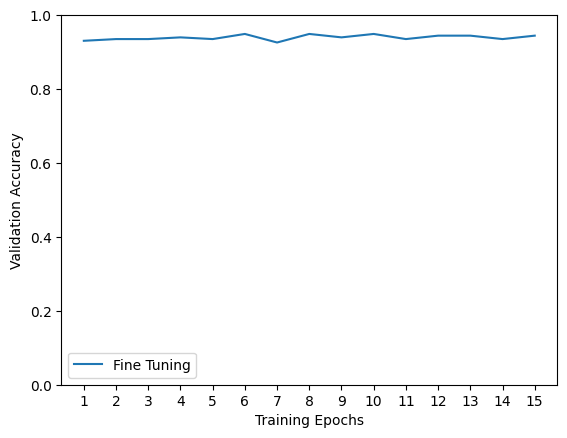

In [ ]:
fhist = []

fhist = [h.cpu().numpy() for h in hist]

plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),fhist,label="Fine Tuning")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()